In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score,roc_auc_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "/content/drive/My Drive/data/exlix_binary_claims_w_dates.csv" "exlix_binary_claims_w_dates.csv"

In [4]:
!ls

drive  exlix_binary_claims_w_dates.csv	sample_data


In [0]:
df=pd.read_csv('exlix_binary_claims_w_dates.csv')

In [6]:
df.head

<bound method NDFrame.head of          patient_id  claim_days_cum  ELIX1  ...  ELIX27  ELIX28  ELIX29
0         PAT110736             749      0  ...       0       0       0
1          PAT24603             906      0  ...       0       0       0
2          PAT24603             961      0  ...       0       0       0
3          PAT43862             310      0  ...       0       0       0
4         PAT114707             349      0  ...       0       0       0
...             ...             ...    ...  ...     ...     ...     ...
12132098   PAT94329             933      0  ...       0       0       0
12132099   PAT94329             933      0  ...       0       0       0
12132100   PAT94329            1093      0  ...       0       0       0
12132101  PAT125886             856      0  ...       0       0       0
12132102  PAT125886             884      0  ...       0       0       0

[12132103 rows x 31 columns]>

In [0]:
from sklearn.model_selection import train_test_split

pts = df['patient_id'].unique()

trp, tsp = train_test_split(pts)
tr = df[df['patient_id'].isin(trp)]
ts = df[df['patient_id'].isin(tsp)]

back_window = 20 # this is number of claims
shift = 1 # this is number of claims
# forward window defined in terms of days
forward_window = 365

In [0]:
x_tr = [] # inputs
y_tr = [] # outputs
for p in trp[:10000]:
    pt = tr[tr['patient_id'] == p]
    for t in range(back_window, len(pt)):
        # input variables
        x_tr.append(pt[t-back_window:t].iloc[:,2:])
    
        # output variable
        t_days = pt.iloc[t].claim_days_cum
        y_tr.append(len(pt[(pt['claim_days_cum'] > t_days) & (pt['claim_days_cum'] <= t_days + 365) ]))
    
        #stop looping if past year 2
        if pt.iloc[t].claim_days_cum > 730:
            break   

In [0]:
x_ts = [] # inputs
y_ts = [] # outputs
for p in tsp[:1000]:
    pt = ts[ts['patient_id'] == p]
    for t in range(back_window, len(pt)):
        # input variables
        x_ts.append(pt[t-back_window:t].iloc[:,2:])
    
        # output variable
        t_days = pt.iloc[t].claim_days_cum
        y_ts.append(len(pt[(pt['claim_days_cum'] > t_days) & (pt['claim_days_cum'] <= t_days + 365) ]))
    
        #stop looping if past year 2
        if pt.iloc[t].claim_days_cum > 730:
            break

In [0]:
x_tr_vals = np.array([xx.values for xx in x_tr])
x_ts_vals = np.array([xx.values for xx in x_ts])

In [0]:
y_tr = (np.array(y_tr) >= 100).astype('int')

In [0]:
y_ts = (np.array(y_ts) >= 100).astype('int')

In [13]:
y_tr

array([0, 0, 0, ..., 0, 0, 0])

In [14]:
y_ts

array([0, 0, 0, ..., 0, 0, 0])

In [0]:
elix_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(29, input_shape=(20,29)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

elix_lstm_model.compile(optimizer='adam', loss='binary_crossentropy',
                        metrics=['accuracy'])

In [16]:
elix_lstm_model.fit(x_tr_vals, y_tr, epochs=30,steps_per_epoch=None)

Epoch 1/30
10455/10455 [==============================] - 100s 10ms/step - loss: 0.4817 - accuracy: 0.7744
Epoch 2/30
10455/10455 [==============================] - 101s 10ms/step - loss: 0.4524 - accuracy: 0.7918
Epoch 3/30
10455/10455 [==============================] - 101s 10ms/step - loss: 0.4338 - accuracy: 0.8025
Epoch 4/30
10455/10455 [==============================] - 101s 10ms/step - loss: 0.4193 - accuracy: 0.8117
Epoch 5/30
10455/10455 [==============================] - 101s 10ms/step - loss: 0.4071 - accuracy: 0.8193
Epoch 6/30
10455/10455 [==============================] - 100s 10ms/step - loss: 0.3968 - accuracy: 0.8251
Epoch 7/30
10455/10455 [==============================] - 100s 10ms/step - loss: 0.3886 - accuracy: 0.8294
Epoch 8/30
10455/10455 [==============================] - 101s 10ms/step - loss: 0.3808 - accuracy: 0.8340
Epoch 9/30
10455/10455 [==============================] - 101s 10ms/step - loss: 0.3738 - accuracy: 0.8373
Epoch 10/30
10455/10455 [============

In [20]:
elix_lstm_model.predict_classes(x_ts_vals)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [0]:
predicted = elix_lstm_model.predict_classes(x_ts_vals)

In [22]:
predicted

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [26]:
accuracy = accuracy_score(y_ts,predicted)
print('accuracy', accuracy)

accuracy 0.7287332104292863


In [27]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_ts,predicted).ravel()
print('tp: ', tp)
print('tn: ', tn)
print('fp: ', fp)
print('fn: ', fn)

tp:  3707
tn:  21196
fp:  3752
fn:  5518


In [0]:
precision = tp/(tp+fp)
recall = tp/(tp+fn) 
f1 = (2*precision*recall)/(precision+recall)

In [35]:
print('precision: ', precision)
print('recall: ', recall)
print('f1 score: ', f1)

precision:  0.4969835098538678
recall:  0.40184281842818426
f1 score:  0.44437784703907934


In [0]:
probs = elix_lstm_model.predict(x_ts_vals)

In [0]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_ts, probs)

In [31]:
metrics.auc(fpr, tpr)

0.67128742146809

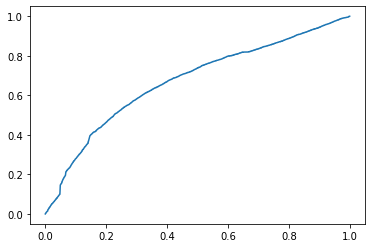

In [32]:
plt.plot(fpr,tpr)